In [1]:
# import necessary Python libraries
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy.optimize import root
from math import gamma as GammaFN
import math

In [2]:
# load data of annual maxima at Azibe Soltane on the Sebou River in Morocca
maxQ = np.loadtxt('Table6.2.csv', skiprows=1, delimiter = ',', usecols=[1])

### 1. 3 Parameter log-normal using MLE

In [3]:
# fit a log-normal distribution to the data
shape, loc, scale = ss.lognorm.fit(maxQ)
shape, loc, scale

(6.7470594316304542, 409.99999999999989, 1.1069460838015344)

In [4]:
math.log(scale)

0.10160494775405472

In [5]:
# convert shape and scale to estimates of mu and sigma
mu_fit_LN = np.log(scale)
sigma_fit_LN = shape

In [6]:
# compute using equations from class for MLE
mu_fit_LN_check = np.mean(np.log(maxQ))
sigma_fit_LN_check = np.sqrt( np.mean( (np.log(maxQ) - mu_fit_LN_check)**2 ) )

In [7]:
# estimate 100-yr flood
q0_99_LN = ss.lognorm.ppf(0.99, shape, loc, scale)
print(q0_99_LN)

7258391.46164


In [8]:
# estimate 500-yr flood
q0_998_LN = ss.lognorm.ppf(0.998, shape, loc, scale)
print(q0_998_LN)

300432788.082


[]

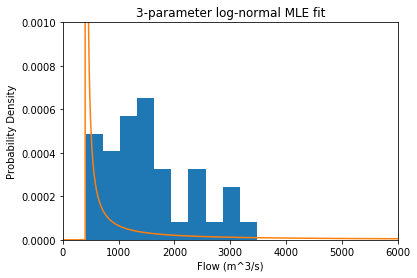

In [9]:
# plot fit on top of histogram
plt.hist(maxQ, density=True)
x = np.arange(0,6500,10)
f_x = ss.lognorm.pdf(x, shape, loc, scale)
plt.plot(x,f_x)
plt.plot([q0_99_LN,q0_99_LN],[0,0.001],c='k')
plt.plot([q0_998_LN,q0_998_LN],[0,0.001],c='k')
plt.ylim([0,0.001])
plt.xlim([0,6000])
plt.title('3-parameter log-normal MLE fit')
plt.xlabel('Flow (m^3/s)')
plt.ylabel('Probability Density')
#plt.savefig('LN3_MLE_fit.png')
plt.plot()

### 2. 2 or 3-parameter Gamma using MLE or MoM

In [10]:
def fitGamma(data, method, npars):
    assert method == 'MLE' or method == 'MOM',"method must = 'MLE' or 'MOM'"
    assert npars == 2 or npars == 3,"npars must = 2 or 3"
    
    xbar = np.mean(data)
    std = np.std(data, ddof=1)
    skew = ss.skew(data,bias=False)

    if method == 'MLE':
        if npars == 2:
            shape, loc, scale = ss.gamma.fit(data,floc=0)
        elif npars == 3:
            shape, loc, scale = ss.gamma.fit(data)
            
        alpha = shape
        beta = 1/scale
        xi = loc
    elif method == 'MOM':
        if npars == 2:
            alpha = xbar**2/std**2
            beta = xbar/std**2
            xi = 0
        elif npars == 3:
            alpha = 4/skew**2
            beta = (2/skew)/std
            xi = xbar - alpha/beta
    
    return alpha, beta, xi

In [11]:
def findGammaReturnPd(data, alpha, beta, xi, T):
    shape = alpha
    loc = xi
    scale = 1/beta
    
    q_T = ss.gamma.ppf(1-1/T, shape, loc, scale)
    
    return q_T

In [12]:
alpha_MOM2, beta_MOM2, xi_MOM2 = fitGamma(maxQ, 'MOM', 2)
alpha_MOM2, beta_MOM2, xi_MOM2

(3.6265715496420841, 0.002340931803280457, 0)

In [13]:
q_100_MOM2 = findGammaReturnPd(maxQ, alpha_MOM2, beta_MOM2, xi_MOM2, 100)
q_500_MOM2 = findGammaReturnPd(maxQ, alpha_MOM2, beta_MOM2, xi_MOM2, 500)
q_100_MOM2, q_500_MOM2

(4034.3490576326421, 4923.0429984035936)

[]

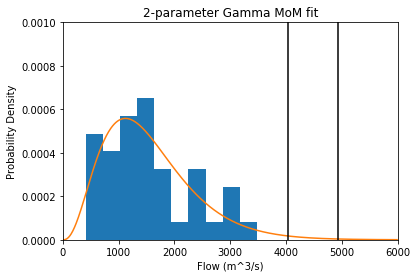

In [14]:
# plot fit on top of histogram
plt.hist(maxQ, density=True)
x = np.arange(0,6000,10)
f_x = ss.gamma.pdf(x, alpha_MOM2, xi_MOM2, 1/beta_MOM2)  
plt.plot(x,f_x)
plt.plot([q_100_MOM2,q_100_MOM2],[0,0.001],c='k')
plt.plot([q_500_MOM2,q_500_MOM2],[0,0.001],c='k')
plt.ylim([0,0.001])
plt.xlim([0,6000])
plt.title('2-parameter Gamma MoM fit')
plt.xlabel('Flow (m^3/s)')
plt.ylabel('Probability Density')
#plt.savefig('LN3_MLE_fit.png')
plt.plot()

In [15]:
alpha_MLE2, beta_MLE2, xi_MLE2 = fitGamma(maxQ, 'MLE', 2)
alpha_MLE2, beta_MLE2, xi_MLE2

(3.643395219880583, 0.0023517913890269706, 0)

In [16]:
q_100_MLE2 = findGammaReturnPd(maxQ, alpha_MLE2, beta_MLE2, xi_MLE2, 100)
q_500_MLE2 = findGammaReturnPd(maxQ, alpha_MLE2, beta_MLE2, xi_MLE2, 500)
q_100_MLE2, q_500_MLE2

(4027.3426510454819, 4912.9233359430336)

[]

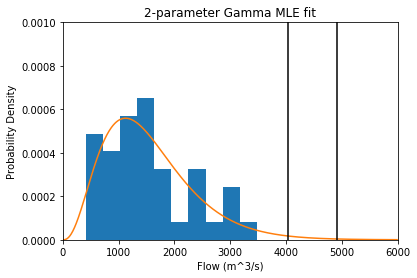

In [17]:
# plot fit on top of histogram
plt.hist(maxQ, density=True)
x = np.arange(0,6000,10)
f_x = ss.gamma.pdf(x, alpha_MLE2, xi_MLE2, 1/beta_MLE2)  
plt.plot(x,f_x)
plt.plot([q_100_MLE2,q_100_MLE2],[0,0.001],c='k')
plt.plot([q_500_MLE2,q_500_MLE2],[0,0.001],c='k')
plt.ylim([0,0.001])
plt.xlim([0,6000])
plt.title('2-parameter Gamma MLE fit')
plt.xlabel('Flow (m^3/s)')
plt.ylabel('Probability Density')
#plt.savefig('LN3_MLE_fit.png')
plt.plot()

### 3. Log-Pearson Type 3 using MLE or MoM

In [44]:
def fitGamma(data, method):
    assert method == 'MLE' or method == 'MOM',"method must = 'MLE' or 'MOM'"
    
    xbar = np.mean(data)
    std = np.std(data, ddof=1)
    skew = ss.skew(data,bias=False)

    if method == 'MLE':
        shape, loc, scale = ss.gamma.fit(np.log(data))
            
        alpha = shape
        beta = 1/scale
        xi = loc
    elif method == 'MOM':
        alpha = 4*(xbar**3)/xbar**2
        beta = xbar/2/xbar**0.5
        xi = xbar - alpha*beta
    
    return alpha, beta, xi

In [45]:
alpha, beta, xi = fitGamma(maxQ, 'MLE')
alpha, beta, xi

(320.07965927648956, 31.834390381442926, -2.8526472504084559)

In [46]:
# estimate 100-yr flood
q0_99 = ss.gamma.ppf(0.99, alpha, xi, 1/beta)
math.exp(q0_99)

5194.088978287922

In [47]:
# estimate 500-yr flood
q0_998 = ss.gamma.ppf(0.998, alpha, xi, 1/beta)
math.exp(q0_998)

7301.308478863522

In [48]:
q_100_MLE2 = findGammaReturnPd(maxQ, alpha, beta, xi, 100)
q_500_MLE2 = findGammaReturnPd(maxQ, alpha, beta, xi, 500)
q_100_MLE2, q_500_MLE2

(8.5552765230516865, 8.895808854754188)

[]

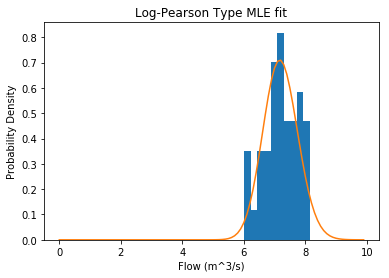

In [49]:
plt.hist(np.log(maxQ), density=True)
x = np.arange(0,10,0.1)
f_x = ss.gamma.pdf(x, alpha, xi, 1/beta)
plt.plot(x,f_x)
plt.title('Log-Pearson Type MLE fit')
plt.xlabel('Flow (m^3/s)')
plt.ylabel('Probability Density')
#plt.savefig('LN3_MLE_fit.png')
plt.plot()

In [24]:
alpha, beta, xi = fitGamma(maxQ, 'MOM')
alpha, beta, xi

(6196.8000000000002, 19.679939024295784, -120403.44614575613)

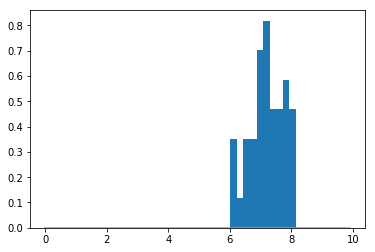

In [25]:
plt.hist(np.log(maxQ), density=True)
x = np.arange(0,10,0.1)
f_x = ss.gamma.pdf(x, alpha, xi, 1/beta)
plt.plot(x,f_x)

### 4. Gumbel Distribution

In [28]:
# fit a Gumbel distribution to the data
loc, scale = ss.gumbel_r.fit(maxQ)
loc, scale

(1177.4043092004997, 629.37985082946693)

In [29]:
1/scale

0.0015888656090309987

In [30]:
# estimate 100-yr flood
q0_99 = ss.gumbel_r.ppf(0.99, loc, scale)
print(q0_99)

4072.64554334


In [31]:
# estimate 500-yr flood
q0_998 = ss.gumbel_r.ppf(0.998, loc, scale)
print(q0_998)

5088.12352218


[]

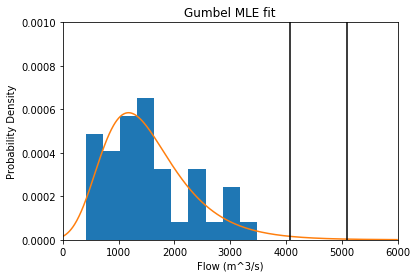

In [32]:
# plot fit on top of histogram
plt.hist(maxQ, density=True)
x = np.arange(0,6000,10)
f_x = ss.gumbel_r.pdf(x, loc, scale)
plt.plot(x,f_x)
plt.plot([q0_99,q0_99],[0,0.001],c='k')
plt.plot([q0_998,q0_998],[0,0.001],c='k')
plt.ylim([0,0.001])
plt.xlim([0,6000])
plt.title('Gumbel MLE fit')
plt.xlabel('Flow (m^3/s)')
plt.ylabel('Probability Density')
#plt.savefig('LN3_MLE_fit.png')
plt.plot()

### 5. GEV Distribution

In [50]:
# fit a GEV distribution to the data
shape, loc, scale = ss.genextreme.fit(maxQ)
shape, loc, scale

(-0.035918510561574524, 1165.3845010967693, 620.22830380050584)

In [51]:
# estimate 100-yr flood
q0_99 = ss.genextreme.ppf(0.99, shape, loc, scale)
print(q0_99)

4267.77719058


In [52]:
# estimate 500-yr flood
q0_998 = ss.genextreme.ppf(0.998, shape, loc, scale)
print(q0_998)

5483.15992777


[]

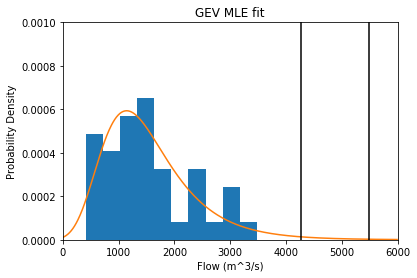

In [53]:
# plot fit on top of histogram
plt.hist(maxQ, density=True)
x = np.arange(0,6000,10)
f_x = ss.genextreme.pdf(x, shape, loc, scale)
plt.plot(x,f_x)
plt.plot([q0_99,q0_99],[0,0.001],c='k')
plt.plot([q0_998,q0_998],[0,0.001],c='k')
plt.ylim([0,0.001])
plt.xlim([0,6000])
plt.title('GEV MLE fit')
plt.xlabel('Flow (m^3/s)')
plt.ylabel('Probability Density')
#plt.savefig('LN3_MLE_fit.png')
plt.plot()